# Historical Baseball Dashboard

This application is a portfolio project built using Plotly's Dash, faculty.ai's Dash Bootstrap Components, and Pandas.
Using historical MLB (Major League Baseball) data, this application provides visualizations for team and player
statistics dating from 1903 to 2020. Selecting from a dropdown menu, the era will update the list of available
teams and players in the range set on the years slider. The slider allows the user to adjust the range of years
with wich the data is presented.

## The Analysis

The applicaiton breaks down each baseballs teams win/loss performance within a range of the teams history.
Additionally, the application will break down the batting performance with the team batting average, BABIP, and strikeout
rate. The application also brakes down the piching perfomance using the teams ERA and strikeout to walk ratio. Finally the feilding
performance of each team is illustrated with total errors and double plays. The applicaiton will also breakdown
each of teams players statistics within the given era.

## Dependencies (Notebook)

- Pandas 1.1
- matplotlib 3.2.2

## The Data

The data used in this application was retrieved from [Seanlahman.com](http://www.seanlahman.com/baseball-archive/statistics/).
Provided by [Chadwick Baseball Bureau's GitHub](https://github.com/chadwickbureau/baseballdatabank/) . 
This database is copyright 1996-2021 by Sean Lahman. This data is licensed under a Creative Commons Attribution-ShareAlike 
3.0 Unported License. For details see: [CreativeCommons](http://creativecommons.org/licenses/by-sa/3.0/)

In [1]:
# Import CSV and Pandas libraries
import csv
import pandas as pd

## Team CSV Data
Using the pandas replace function, some team names where altered to their modern counterpart to better fit analysis and provide better continuity.

### The following are alerations made to team names
 - Boston Beaneaters, Boston Doves, Boston Bees, Boston Rustlers: Boston Braves
 - Boston Americans: Boston Red Sox
 - New York Highlanders: New York Yankees
 - Brooklyn Superbas, Brooklyn Robins: Booklyn Dodgers
 - Houston Colt .45's: Huston Astros
 - California Angels, Anaheim Angels, Los Angeles Angels of Anaheim: Los Angeles Angeles
 - Philadelphia Blue Jays: Philadelphia Phillies
 - Cincinnati Redlegs: Cincinnati Reds

Further more, the id's of the Los Angeles Angeles (ANA and CAL) was replaced with 'LAA' to connect all players through out the teams history.

In [3]:
teams_df = pd.read_csv('update_team.csv')

## Listing Teams in Given Era

The history of Major League Baseball (MLB) can be broken into era's, each represents a period of signigicant change in MLB's history. The following will provide functions that are necessary in dynamically creating a list of team names paired with their ID. 

In [5]:
# Function that will create a list of teams based on era
def dynamicera(new,x):
    team_names = teams_df[['year','name','team_id']]
    filter_year = team_names[team_names.year <= new[x][1]]
    filter_year = filter_year[filter_year.year >= new[x][0]]
    filter_team = filter_year['name'].unique()
    filter_team_ids = filter_year['team_id'].unique()
    # Updated, key value pair with team name and team id
    return [{'label': k, 'value': v }for k, v in zip(filter_team, filter_team_ids)]

# list of Era names used here for reference
# Dead Ball, Live Ball, Integration, Expantion, Free-Agency, Steroid, Post-Steroid
# Hard coded time list corresponds to the era list
time_list = [(1903,1919),(1920,1941),(1942,1960),(1961,1976),(1977,1993),(1994,2005),(2005,2015)]

# Set list of team names from the 'Expantion Era' using the dynamic teams function
teamname = dynamicera(time_list,3)
print(teamname)

[{'label': 'Baltimore Orioles', 'value': 'BAL'}, {'label': 'Boston Red Sox', 'value': 'BOS'}, {'label': 'Chicago White Sox', 'value': 'CHA'}, {'label': 'Chicago Cubs', 'value': 'CHN'}, {'label': 'Cincinnati Reds', 'value': 'CIN'}, {'label': 'Cleveland Indians', 'value': 'CLE'}, {'label': 'Detroit Tigers', 'value': 'DET'}, {'label': 'Kansas City Athletics', 'value': 'KC1'}, {'label': 'Los Angeles Angels', 'value': 'LAA'}, {'label': 'Los Angeles Dodgers', 'value': 'LAN'}, {'label': 'Minnesota Twins', 'value': 'MIN'}, {'label': 'Milwaukee Braves', 'value': 'ML1'}, {'label': 'New York Yankees', 'value': 'NYA'}, {'label': 'Philadelphia Phillies', 'value': 'PHI'}, {'label': 'Pittsburgh Pirates', 'value': 'PIT'}, {'label': 'San Francisco Giants', 'value': 'SFN'}, {'label': 'St. Louis Cardinals', 'value': 'SLN'}, {'label': 'Washington Senators', 'value': 'WS2'}, {'label': 'Houston Astros', 'value': 'HOU'}, {'label': 'New York Mets', 'value': 'NYN'}, {'label': 'Atlanta Braves', 'value': 'ATL'},

In [6]:
# Function that maintains an era range
def dynamicrange(x):
    # Hardcoded list of era time spans
    era_time = [(1903,1919),
                (1920,1941),
                (1942,1960),
                (1961,1976),
                (1977,1993),
                (1994,2005),
                (2006,2015)]
    filter_range = [era_time[x][0],era_time[x][1]]
    return filter_range

# Hardcoded list of era key value pair
era_list = [{'label': 'Dead Ball','value': 'Dead Ball'},{'label': 'Live Ball','value': 'Live Ball'},{'label': 'Integration','value': 'Integration'},{'label': 'Expantion','value': 'Expantion'},{'label': 'Free Agency','value': 'Free Agency'},{'label': 'Steroid','value': 'Steroid'},{'label': 'Post-Steroid','value': 'Post-Steroid'}]

# set era range
year_range = dynamicrange(2)
# set team names
era_teams = dynamicera(time_list,2)

# Print Era
print(era_list[2]['value'])
# Print Era span (Year range)
print(year_range)
# Teams from era
print(era_teams)

Integration
[1942, 1960]
[{'label': 'Boston Red Sox', 'value': 'BOS'}, {'label': 'Brooklyn Dodgers', 'value': 'BRO'}, {'label': 'Boston Braves', 'value': 'BSN'}, {'label': 'Chicago White Sox', 'value': 'CHA'}, {'label': 'Chicago Cubs', 'value': 'CHN'}, {'label': 'Cincinnati Reds', 'value': 'CIN'}, {'label': 'Cleveland Indians', 'value': 'CLE'}, {'label': 'Detroit Tigers', 'value': 'DET'}, {'label': 'New York Giants', 'value': 'NY1'}, {'label': 'New York Yankees', 'value': 'NYA'}, {'label': 'Philadelphia Athletics', 'value': 'PHA'}, {'label': 'Philadelphia Phillies', 'value': 'PHI'}, {'label': 'Pittsburgh Pirates', 'value': 'PIT'}, {'label': 'St. Louis Browns', 'value': 'SLA'}, {'label': 'St. Louis Cardinals', 'value': 'SLN'}, {'label': 'Washington Senators', 'value': 'WS1'}, {'label': 'Milwaukee Braves', 'value': 'ML1'}, {'label': 'Baltimore Orioles', 'value': 'BAL'}, {'label': 'Kansas City Athletics', 'value': 'KC1'}, {'label': 'Los Angeles Dodgers', 'value': 'LAN'}, {'label': 'San Fr

## Analysis (Team Data)

Once an era is selected the list of available teams is updated. Each team performance is analyzed for Wins and Losses, Batting, Fielding, and Pitching. Team data is also analyzed for championship wins.

In [7]:
# This filter dataframe represents the era range being applied
filter_df = teams_df[(teams_df.year >= 1920)&(teams_df.year <= 1941)]

In [8]:
# Create dataframe of accolades, New York Yankees from filter_df set to 1920 -1941
Data = filter_df[filter_df.team_id == 'NYA'].drop(columns=['team_id', 'g', 'w', 'l', 'r', 'ab', 'h', 'double', 'triple', 
        'hr', 'bb', 'so', 'sb', 'cs', 'era', 'cg', 'sho', 'sv', 'ha', 'hra', 'bba', 'soa', 'e', 'dp', 
        'fp', 'name', 'park'])

In [9]:
# Set data to variable and check if there was a world series win
WIN = Data[Data.ws_win == 'Y']
# if empty (no World Series win)
if WIN.empty:
    # set data to check if wild card was won
    WIN = Data[Data.wc_win == 'Y']
    # if empty (no Wild Card win)
    if WIN.empty:
        # set data to check if there as a division win
        WIN = Data[Data.div_win == 'Y']

WIN

,year,league_id,franchise_id,div_id,rank,ghome,div_win,wc_win,lg_win,ws_win,...,sf,ra,er,ipouts,attendance,bpf,ppf,team_id_br,team_id_lahman45,team_id_retro
760,1923,AL,NYY,NaN,1,76.0,NaN,NaN,Y,Y,...,NaN,622,555,4140,1007066.0,103,100,NYY,NYA,NYA
824,1927,AL,NYY,NaN,1,77.0,NaN,NaN,Y,Y,...,NaN,599,494,4167,1164015.0,98,94,NYY,NYA,NYA
840,1928,AL,NYY,NaN,1,77.0,NaN,NaN,Y,Y,...,NaN,685,571,4125,1072132.0,98,94,NYY,NYA,NYA
904,1932,AL,NYY,NaN,1,77.0,NaN,NaN,Y,Y,...,NaN,724,623,4224,962320.0,96,92,NYY,NYA,NYA
968,1936,AL,NYY,NaN,1,77.0,NaN,NaN,Y,Y,...,NaN,731,649,4200,976913.0,97,93,NYY,NYA,NYA
984,1937,AL,NYY,NaN,1,79.0,NaN,NaN,Y,Y,...,NaN,671,566,4188,998148.0,102,97,NYY,NYA,NYA
1000,1938,AL,NYY,NaN,1,79.0,NaN,NaN,Y,Y,...,NaN,710,600,4146,970916.0,100,95,NYY,NYA,NYA
1016,1939,AL,NYY,NaN,1,77.0,NaN,NaN,Y,Y,...,NaN,556,496,4044,859785.0,99,95,NYY,NYA,NYA
1048,1941,AL,NYY,NaN,1,78.0,NaN,NaN,Y,Y,...,NaN,631,548,4188,964722.0,99,95,NYY,NYA,NYA


<AxesSubplot:xlabel='year'>

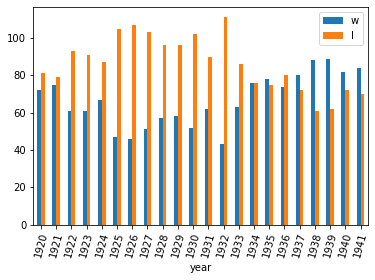

In [10]:
# This is the plot of the filtered team data
filter_df[filter_df.team_id == 'BOS'].plot.bar(x='year',y=['w','l'],rot=75)
# If the above example of features are applied the graph should look similar
# WIN LOSE BAR GRAPH OF THE BOSTON RED SOX DURING THE 'LIVE BALL' ERA

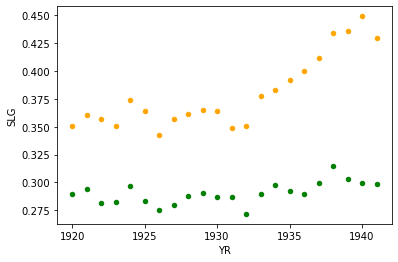

In [11]:
# import matplot lib to plot multiple graphs
import matplotlib.pyplot as plt
# set axis
ax = plt.gca()

# Using the filterd data from above, Live Ball Era
YR = filter_df[filter_df.team_id == 'BOS'].year
AB = filter_df[filter_df.team_id == 'BOS'].ab
Ht = filter_df[filter_df.team_id == 'BOS'].h
SO = filter_df[filter_df.team_id == 'BOS'].so
BB = filter_df[filter_df.team_id == 'BOS'].bb
HR = filter_df[filter_df.team_id == 'BOS'].hr
Db = filter_df[filter_df.team_id == 'BOS'].double
Tr = filter_df[filter_df.team_id == 'BOS'].triple
# Calculate singles
Sg = Ht - Db - Tr - HR

# Calculate Slugging average
SLG = (Sg + 2*Db + 3*Tr + 4*HR)/AB
# Calculate Batting Average Balls In Play (BABIP)
BABIP = (Ht - HR) / (AB - SO - HR)

# Set graph data
Data = {'YR': YR,
        'BABIP': BABIP,
        'SLG': SLG}

# set new dataframe for graph
df = pd.DataFrame(Data,columns=['YR','BABIP','BAVG','SLG'])
# Apply new dataframe (filtered and calculated data using 'Live Ball' era data)
df.plot.scatter(x='YR', y='BABIP',ax=ax,color='green')
df.plot.scatter(x='YR', y='SLG',ax=ax,color='orange')
plt.show()
# SLUGGING AVERAGE AND BABIP LINE GRAPH OF THE BOSTON RED SOX DURING THE 'LIVE BALL' ERA

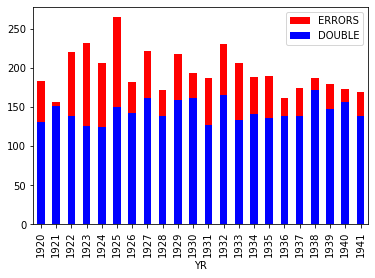

In [12]:
# Create new axes
ax = plt.gca()

# Set variables with filtered (Live Ball) data
YR = filter_df[filter_df.team_id == 'BOS'].year
ERR = filter_df[filter_df.team_id == 'BOS'].e
DP = filter_df[filter_df.team_id == 'BOS'].dp

# Set data for graph
Data = {'YR': YR,
        'ERRORS': ERR,
        'DOUBLE': DP}

# Create new dataframe to use for graph
df = pd.DataFrame(Data,columns=['YR','ERRORS','DOUBLE'])
# Apply new dataframe to bar graph
df.plot.bar(x='YR', y='ERRORS',ax=ax,color='red')
df.plot.bar(x='YR', y='DOUBLE',ax=ax,color='blue')
plt.show()
# ERRORS AND DOUBLE PLAYS BAR GRAPH OF THE BOSTON RED SOX DURING THE 'LIVE BALL' ERA

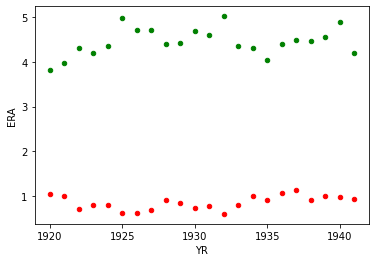

In [13]:
# Set new axes
ax = plt.gca()

# Create variables needed for new graph
YR = filter_df[filter_df.team_id == 'BOS'].year
ERA = filter_df[filter_df.team_id == 'BOS'].era
SOA = filter_df[filter_df.team_id == 'BOS'].soa
BBA = filter_df[filter_df.team_id == 'BOS'].bba
# Calculate strike out rate
SOR = SOA / BBA

# Set data for graph
Data = {'YR': YR,
        'ERA': ERA,
        'SOR': SOR}

# Create dataframe for graph
df = pd.DataFrame(Data,columns=['YR','ERA','SOR'])
# Apply new dataframe to line graph
df.plot.scatter(x='YR', y='SOR',ax=ax,color='red')
df.plot.scatter(x='YR', y='ERA',ax=ax,color='green')
plt.show()
# ERA (Earned Run Average) AND STRIKEOUT RATE LINE GRAPH OF THE BOSTON RED SOX DURING THE 'LIVE BALL' ERA

## Players CSV Data

While the available teams are altered based on era, available players are adjusted based on selected team within the given era. This means only players within the given era and team are available. Some players span multiple eras as well as multiple teams. Player analysis is only based on year range of era and selected team. Analysis consists of Batting and Fielding\Pitching performance. To allow for better continuity through out the Los Angeles Angels player history, the team id was adjusted, replacing ANA, CAL id with LAA team id. Additionally the players known name is created from combining first and last name columns into a known_name column.

In [14]:
team_player = pd.read_csv('player_team.csv')
players_df = pd.read_csv('update_player.csv')

## Listing Players in Selected Era and Team

The player data is made of two csv files, the player_team and player csv files. The player_team csv is needed to query player id and player's team id along with rage of years in service to selected team. The player csv is used to query selected player profile.

In [16]:
# Select team, Los Angeles Angels
select_team = team_player[team_player.team_id == 'LAA']
# Select year range 'Free Agency' era
select_year = select_team[(select_team.year >= 1977)&(select_team.year <= 1993)]

# create key value pair list of players known names and player id
temp_list = [{'label': k, 'value': v }for k, v in zip(select_year.known_name, select_year.player_id)]

# create empty list
player_list = []
# set unique player names and ids in a new list
[player_list.append(x) for x in temp_list if x not in player_list]
print(player_list)

[{'label': 'Don Aase', 'value': 'aasedo01'}, {'label': 'Jim Abbott', 'value': 'abbotji01'}, {'label': 'Kyle Abbott', 'value': 'abbotky01'}, {'label': 'Shawn Abner', 'value': 'abnersh01'}, {'label': 'Ricky Adams', 'value': 'adamsri02'}, {'label': 'Willie Aikens', 'value': 'aikenwi01'}, {'label': 'Ruben Amaro', 'value': 'amaroru02'}, {'label': 'Brian Anderson', 'value': 'anderbr02'}, {'label': 'Jim Anderson', 'value': 'anderji01'}, {'label': 'Kent Anderson', 'value': 'anderke01'}, {'label': 'Tony Armas', 'value': 'armasto01'}, {'label': 'Stan Bahnsen', 'value': 'bahnsst01'}, {'label': 'Scott Bailes', 'value': 'bailesc01'}, {'label': 'Floyd Bannister', 'value': 'bannifl01'}, {'label': 'Mike Barlow', 'value': 'barlomi01'}, {'label': 'Jim Barr', 'value': 'barrji01'}, {'label': 'Don Baylor', 'value': 'baylodo01'}, {'label': 'Chris Beasley', 'value': 'beaslch01'}, {'label': 'Juan Beniquez', 'value': 'beniqju01'}, {'label': 'Dante Bichette', 'value': 'bicheda01'}, {'label': 'Bert Blyleven', 'v

In [17]:
# select player, Bob Boone
select_team[select_team.player_id == 'boonebo01']

,player_id,known_name,team_id,year
9183,boonebo01,Bob Boone,LAA,1982.0
9184,boonebo01,Bob Boone,LAA,1983.0
9185,boonebo01,Bob Boone,LAA,1984.0
9186,boonebo01,Bob Boone,LAA,1985.0
9187,boonebo01,Bob Boone,LAA,1986.0
9188,boonebo01,Bob Boone,LAA,1987.0
9189,boonebo01,Bob Boone,LAA,1988.0


In [18]:
# Bob Boone Profile
players_df[players_df.player_id == 'boonebo01']

,player_id,birth_year,birth_month,birth_day,birth_country,birth_state,birth_city,death_year,death_month,death_day,...,name_last,name_given,weight,height,bats,throws,debut,final_game,retro_id,bbref_id
1689,boonebo01,1947.0,11.0,19.0,USA,CA,San Diego,NaN,NaN,NaN,...,Boone,Robert Raymond,195.0,74.0,R,R,1972-09-10,1990-09-27,boonb001,boonebo01


## Analysis (Player)

Similar to team analysis, once an era and team are selected, the available players list is updated. Players batting performance and pitching/fielding performance are analyzed.

In [19]:
batting_df = pd.read_csv('update_batting.csv')

In [20]:
# Filter team
filter_batting_team = batting_df[batting_df.team_id == 'LAA']

In [21]:
# Filter year range
filter_batting_year = filter_batting_team[(filter_batting_team.year >= 2006)&(filter_batting_team.year <= 2015)]

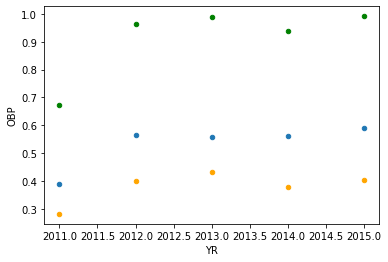

In [22]:
# set axis
ax = plt.gca()

# Using the filterd data from above, Live Ball Era
YR = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].year
AB = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].ab
Ht = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].h
SO = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].so
BB = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].bb
HBP = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].hbp
SF = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].sf
HR = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].hr
Db = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].double
Tr = filter_batting_year[filter_batting_year.player_id == 'troutmi01'].triple
# Calculate singles
Sg = Ht - Db - Tr - HR

# Calculate On-Base Percentage
OBP = (Ht + BB + HBP) / (AB + BB + HBP + SF)
# Calculate Slugging average
SLG = (Sg + 2*Db + 3*Tr + 4*HR)/AB
# Calculate On-Base Plus Slugging
OPS = OBP + SLG

# Set graph data
Data = {'YR': YR,
        'OPS': OPS,
        'OBP': OBP,
        'SLG': SLG}

# set new dataframe for graph
df = pd.DataFrame(Data,columns=['YR','OPS','OBP','SLG'])
# Apply new dataframe (filtered and calculated data using 'Live Ball' era data)
df.plot.scatter(x='YR', y='OPS',ax=ax,color='green')
df.plot.scatter(x='YR', y='SLG',ax=ax)
df.plot.scatter(x='YR', y='OBP',ax=ax,color='orange')
plt.show()
# OPS, SLUGGING, AND OBP LINE GRAPH OF MIKE TROUT DURING THE 'Post Steroid' ERA

## Fielding and Pitching CSV Data

Fielding and pitching team_id was updated, replacing 'ANA' and 'CAL' with 'LAA'.

In [23]:
field_df = pd.read_csv('update_fielding.csv')
pitch_df = pd.read_csv('update_pitching.csv')

## Analysis (Fielding/Pitching)

Simlar to player analysis, the selected era and team will dictate available players for analysis. Each player is evaluated for their position, once thier position is determained the players fielding and or pitching data can be processed.

In [24]:
# Filter team
filter_pitch_team = pitch_df[pitch_df.team_id == 'HOU']

In [25]:
# Filter year range
filter_pitch_year = filter_pitch_team[(filter_pitch_team.year >= 1977)&(filter_pitch_team.year <= 1993)]

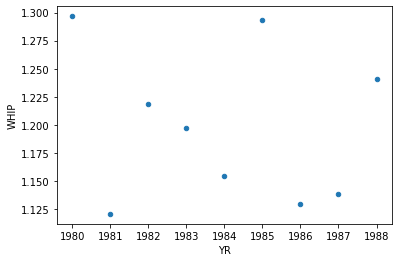

In [26]:
# set axis
ax = plt.gca()

# Using the filterd data from above, Live Ball Era
YR = filter_pitch_year[filter_pitch_year.player_id == 'ryanno01'].year
IPO = filter_pitch_year[filter_pitch_year.player_id == 'ryanno01'].ipouts
BB = filter_pitch_year[filter_pitch_year.player_id == 'ryanno01'].bb
H = filter_pitch_year[filter_pitch_year.player_id == 'ryanno01'].h
IP = IPO / 3

WHIP = (BB + H) / IP

# Set graph data
Data = {'YR': YR,
        'WHIP': WHIP}

# set new dataframe for graph
df = pd.DataFrame(Data,columns=['YR','WHIP'])
# Apply new dataframe (filtered and calculated data using 'Live Ball' era data)
df.plot.scatter(x='YR', y='WHIP',ax=ax)
plt.show()
# WHIP LINE GRAPH OF NOLAN RYAN DURING THE 'Free Agency' ERA

In [27]:
# Filter team
filter_field_team = field_df[field_df.team_id == 'HOU']

In [28]:
# Filter year range
filter_field_year = filter_field_team[(filter_field_team.year >= 1977)&(filter_field_team.year <= 1993)]

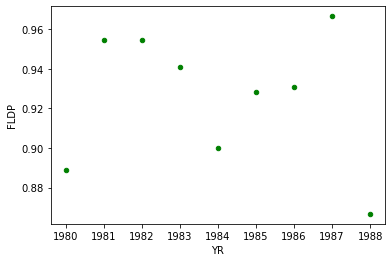

In [29]:
# set axis
ax = plt.gca()

# Using the filterd data from above, Live Ball Era
YR = filter_field_year[filter_field_year.player_id == 'ryanno01'].year
PO = filter_field_year[filter_field_year.player_id == 'ryanno01'].po
ASS = filter_field_year[filter_field_year.player_id == 'ryanno01'].a
ERR = filter_field_year[filter_field_year.player_id == 'ryanno01'].e

FLDP = (PO + ASS) / (PO + ASS + ERR)

# Set graph data
Data = {'YR': YR,
        'FLDP': FLDP}

# set new dataframe for graph
df = pd.DataFrame(Data,columns=['YR','FLDP'])
# Apply new dataframe (filtered and calculated data using 'Live Ball' era data)
df.plot.scatter(x='YR', y='FLDP',ax=ax,color='green')
plt.show()
# FIELDING PERCENTAGE (FLDP) LINE GRAPH OF NOLAN RYAN DURING THE 'Free Agency' ERA

## Conclusion

The graphs and data shown in this notebook will be used to create an application using Plotly Dash, analysing team and player data from 1903 to 2015. Each area of analysis (team, batting, pitching/fielding) will be contained in a single page within the applicaiton. Graphs and analysis are subject to change as they are implemented.